In [2]:
# Run Twice
import sys
sys.executable
!/opt/conda/bin/python -m pip install boto3

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
pip install psycopg2

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn --upgrade --user

Requirement already up-to-date: seaborn in /home/ubuntu/.local/lib/python3.6/site-packages (0.11.2)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --user -U numpy

Requirement already up-to-date: numpy in /home/ubuntu/.local/lib/python3.6/site-packages (1.19.5)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install --user -U sklearn

Requirement already up-to-date: sklearn in /home/ubuntu/.local/lib/python3.6/site-packages (0.0)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install --user xgboost

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import numpy as np
import pandas as pd
import boto3
import json
import os
import ast
import csv
import io
from io import StringIO, BytesIO, TextIOWrapper
import gzip
from datetime import datetime, date
from s3_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import ast
from datetime import timedelta
from tqdm import tqdm

# import tslearn
try:
    import torch
except: pass

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def largestDivisibleByKLessThanN(N, K):
    rem = N % K
    if(rem == 0):
        return N
    else:
        return N - rem
    
def zScore(x, dim=0):
    if isinstance(x, pd.core.frame.DataFrame):
        return (x - np.mean(x.to_numpy(), dim, keepdims=True)) / (np.std(x.to_numpy(), dim, keepdims=True) + 1e-7)
    else:
        return (x - np.mean(x, dim, keepdims=True)) / (np.std(x, dim, keepdims=True) + 1e-7)
    
def nanzScore(x, dim=0):
    if isinstance(x, pd.core.frame.DataFrame):
        return (x - np.nanmean(x.to_numpy(), dim, keepdims=True)) / (np.nanstd(x.to_numpy(), dim, keepdims=True) + 1e-7)
    else:
        return (x - np.nanmean(x, dim, keepdims=True)) / (np.nanstd(x, dim, keepdims=True) + 1e-7)

# If version is not 0.11.2, restart kernel and rerun ONLY this block
sns.__version__

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-tv7to9gf because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


'0.11.2'

In [10]:
# Define s3 bucket
bucket = 'fouryouandme-study-data'

#List s3 keys
# get_matching_s3_keys(bucket, prefix='bump/') #Remove prefix to view non-BUMP data
bucket = '4youandme-study-data' # for SinC project
bucket = 'fouryouandme-study-data' # for 4YouandMe, Bump, CamCog or Bodyport project

# prefix = {study_name} or {study_name}/{source}
# sources: app_activities, bodyport, camcog, garmin, oura, redcap, rescuetime
# note camcog not accessible to bodyport (and vice a versa)
get_matching_s3_keys(bucket, prefix='bump/oura')

# Study IDs

key = 'bump/redcap/wave_2/study_ids.csv.gz'
df_studyID = pandas_from_csv_s3(bucket, key=key, compression='gzip')

# Some dataframes use 'record_id' instead of 'user_id'. 
# You'll need to match it up with df_studyID where'evidation_id' is 'user_id'
# NOTE: Very few examples of this. Birthing data is the important one

# Birthing Data
key = 'bump/redcap/wave_2/birthing_data_cohort_2_only.csv.gz'
df_birth = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_birth['date'] = pd.to_datetime(df_birth.birth_date).dt.date


df_birth = pd.merge(df_birth, df_studyID, on='record_id')
df_birth['user_id'] = df_birth.evidation_id

# There is a missing value in the birthing data. I'm removing it here
df_birth = df_birth.drop(index=50)

# Bodyport Wave 2
key = 'bump/bodyport/wave_2/bodyport.csv.gz'
df_bodyport = pandas_from_csv_s3(bucket, key=key, compression='gzip')
# OPTIONAL: Convert date format
df_bodyport['date'] = pd.to_datetime(df_bodyport.event_date).dt.date 

# Oura Wave 2
key = 'bump/oura/wave_2/oura_sleep.csv.gz'
df_sleep = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_sleep['date'] = pd.to_datetime(df_sleep.event_date).dt.date

key = 'bump/oura/wave_2/oura_activity.csv.gz'
df_activity = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_activity['date'] = pd.to_datetime(df_activity.event_date).dt.date

key = 'bump/oura/wave_2/oura_readiness.csv.gz'
df_readiness = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_readiness['date'] = pd.to_datetime(df_readiness.event_date).dt.date

# Surveys Wave 2
key = 'bump/app_activities/wave_2/surveys.csv.gz'
df_survey = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_survey['date'] = pd.to_datetime(df_survey.updated_at).dt.date

key = 'bump/app_activities/wave_2/quick_activities.csv.gz'
df_sam = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_sam['date'] = pd.to_datetime(df_sam.event_date).dt.date

# Daily Symptom Survey Questions (1-7 Likert Scale) (See Data Dictionary) 
nausea = df_survey[df_survey['question_id'] == 203]
fatigue = df_survey[df_survey['question_id'] == 204]
mood = df_survey[df_survey['question_id'] == 205]
breath = df_survey[df_survey['question_id'] == 206]
swollen = df_survey[df_survey['question_id'] == 207]
walk = df_survey[df_survey['question_id'] == 208]
remember = df_survey[df_survey['question_id'] == 209]

In [11]:
dfs = [df_sleep, df_bodyport]
names = []
for df in dfs:
    [names.append(i) for i in df.columns.to_list()]

In [12]:
list(set(names))

['updated_at',
 'rem',
 'score_efficiency',
 'bmi_kg_m2',
 'impedance_mag_1_ohms',
 'device_id',
 'identity_id',
 'event_date',
 'duration',
 'score_disturbances',
 'bedtime_start_delta',
 'score_latency',
 'temperature_deviation',
 'temperature_trend_deviation',
 'onset_latency',
 'retrieved_at',
 'efficiency',
 'restless',
 'impedance_ratio',
 'score_total',
 'score_rem',
 'created_at',
 'hypnogram_5min',
 'id',
 'date',
 'hr_5min',
 'backend_sway_area_mm2',
 'end_code',
 'deep',
 'midpoint_time',
 'is_longest',
 'sway_velocity_mm_sec',
 'impedance_phase_1_degs',
 'timezone',
 'patient_id',
 'peripheral_fluid',
 'total_body_water_percent',
 'muuid',
 'midpoint_at_delta',
 'temperature_delta',
 'bedtime_end_delta',
 'user_id',
 'hr_lowest',
 'heart_rate',
 'subsource',
 'rmssd_5min',
 'awake',
 'score_deep',
 'bedtime_start',
 'total',
 'bedtime_end',
 'light',
 'score',
 'score_alignment',
 'uuid',
 'period_id',
 'breath_average',
 'weight_kg',
 'run_time_sec',
 'hr_average',
 'rmssd

In [13]:
def get_user(user_id, start=None, end=None):
    user_sleep = df_sleep[df_sleep.user_id == user_id]#.dropna()
    user_bp = df_bodyport[df_bodyport.user_id == user_id]#.dropna()
    
    df2 = pd.merge(user_sleep, user_bp, on="date")
    
    # add walk
    user_walk = walk[walk.user_id == user_id].dropna()
    user_walk = user_walk[["answer_text", "date"]].rename(columns={"answer_text" : "walk"})
    user_walk["walk"] = user_walk["walk"].astype(int)
    df2 = pd.merge(df2, user_walk, on="date", how="outer")
    
    # add fatigue
    user_fatigue = fatigue[fatigue.user_id == user_id].dropna()[["answer_text", "date"]].rename(columns={"answer_text" : "fatigue"})
    user_fatigue["fatigue"] = user_fatigue["fatigue"].astype(int)
    df2 = pd.merge(df2, user_fatigue, on="date", how="outer")

    # add mood
    user_mood = mood[mood.user_id == user_id].dropna()[["answer_text", "date"]].rename(columns={"answer_text" : "mood"})
    user_mood = user_mood[["mood", "date"]]
    user_mood["mood"] = user_mood["mood"].astype(int)
    df2 = pd.merge(df2, user_mood, on="date", how="outer")

    
    # add nausea
    user_nausea = nausea[nausea.user_id == user_id].dropna()[["answer_text", "date"]].rename(columns={"answer_text" : "nausea"})
    user_nausea = user_nausea[["nausea", "date"]]
    user_nausea["nausea"] = user_nausea["nausea"].astype(int)
    df2 = pd.merge(df2, user_nausea, on="date", how="outer")
    
    # add breath
    user_breath = breath[breath.user_id == user_id].dropna()[["answer_text", "date"]].rename(columns={"answer_text" : "breath"})
    user_breath = user_breath[["breath", "date"]]
    user_breath["breath"] = user_breath["breath"].astype(int)
    df2 = pd.merge(df2, user_breath, on="date", how="outer")
    
    # add swollen
    user_swollen = swollen[swollen.user_id == user_id].dropna()[["answer_text", "date"]].rename(columns={"answer_text" : "swollen"})
    user_swollen = user_swollen[["swollen", "date"]]
    user_swollen["swollen"] = user_swollen["swollen"].astype(int)
    df2 = pd.merge(df2, user_swollen, on="date", how="outer")
    
    # add remember
    user_remember = remember[remember.user_id == user_id].dropna()[["answer_text", "date"]].rename(columns={"answer_text" : "remember"})
    user_remember = user_remember[["remember", "date"]]
    user_remember["remember"] = user_remember["remember"].astype(int)
    df2 = pd.merge(df2, user_remember, on="date", how="outer")
    

    df2.set_index(df2["date"], inplace=True)
    df2.sort_index(inplace=True)
    if start:
        mask = pd.to_datetime(df2["date"]).between(start.astype(str)[0], end.astype(str)[0], inclusive=True)
        df2 = df2[mask]
    return df2

In [14]:
feature_names = [
#     'bedtime_start_delta',
    'impedance_mag_1_ohms',
    'impedance_phase_1_degs',
#     'bedtime_start',
#     'hypnogram_5min',
    'hr_lowest',
    'impedance_ratio',
#     'total',
#     'rmssd_5min',
    'sway_velocity_mm_sec',
#     'is_longest',
    'peripheral_fluid',
#     'awake',
#     'bedtime_end_delta',
    'score_deep',
    'temperature_deviation',
    'temperature_trend_deviation',
#     'timezone',
    'temperature_delta',
#     'hr_5min',
    'hr_average',
    'duration',
    'rem',
    'rmssd',
    'heart_rate',
    'bmi_kg_m2',
    'efficiency',
    'score_alignment',
    'score_rem',
    'total_body_water_percent',
    'light',
    'onset_latency',
    'restless',
    'breath_average',
    'score_disturbances',
    'score',
    'score_efficiency',
#     'midpoint_time',
    'backend_sway_area_mm2',
    'score_latency',
#     'midpoint_at_delta',
    'score_total',
    'run_time_sec',
#     'bedtime_end',
#     'weight_kg',
#     'end_code',
#     'deep',
]

outcome_names = [
    "walk",
    "fatigue",
    "mood",
    "nausea",
    "breath",
    "swollen",
    "remember",
]

users = []
births = []
no_interp = []
for i, user_id in tqdm(enumerate(df_sleep.user_id.unique())):
    df = get_user(user_id)
    df = df[feature_names + outcome_names + ["date"]]
    if len(df) >= 10: # For those with at least 20 measurements
        df.set_index(pd.to_datetime(df.date), inplace=True)
        df = df.resample("D").mean()
        df.set_index(df.index.day, inplace=True)

        if len(df) > 1:
            users.append(df)

# Make sure no len 0 users slipped through
users = [u for u in users if len(u) > 0]

266it [03:31,  1.26it/s]


# Regression Experiments

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier, XGBRegressor

min_window = 1
max_window = 10

mnames = ["lr"]#, "xgb"]

def getDataset(users, window_size, outcome=None):
    X = []
    Y = []

    # Create dataset (this runs fast)
    for i, item in enumerate(users):
        y = item[outcome_names].to_numpy() # Pull out outcome labels
        if outcome is not None:
            x = item[feature_names + [outcome]].to_numpy() # Drop outcome columns and convert to numpy array
        else:
            x = item.drop(columns=outcome_names).to_numpy() # Drop outcome columns and convert to numpy array
        
        # Offset windows and labels by 1
        x = x[:-1]
        y = y[1:]

        # Chop off last timesteps that aren't divisible
        n = largestDivisibleByKLessThanN(len(x), window_size)
        x, y = x[:n], y[:n]

        x = x.reshape(n//window_size, window_size*x.shape[1])
        y = y.reshape(n//window_size, window_size, -1)[:, -1, :]
        X.append(x)
        Y.append(y)
    
    # Stack and interpolate X
    X = np.vstack(X)
    Y = np.vstack(Y)
    
    X = pd.DataFrame(X).interpolate("linear", 1)
    X = nanzScore(X, 1)
    X = X.fillna(X.mean(0)).to_numpy()
    
    # Split into training and testing
    train_ix = np.random.choice(len(X), int(0.9*len(X)), replace=False)
    test_ix = list(set(np.arange(len(X))) - set(train_ix))
    X_train = X[train_ix]
    X_test = X[test_ix]
    y_train = Y[train_ix]
    y_test = Y[test_ix]
    
    # Fill NANs in y_train and drop NANs in y_tset
    y_train = pd.DataFrame(y_train)
    y_train = y_train.fillna(y_train.mean(0)).to_numpy()
    
    # Standardize y
    y_train = nanzScore(y_train)
    y_test = nanzScore(y_test)

    return X_train, X_test, y_train, y_test
#     return X, y

results_cv = []
for _ in tqdm(range(1)):
    results = []
    for window_size in range(min_window, max_window+1):
        # Split data into windows
        X_train, X_test, y_train, y_test = getDataset(users, window_size)#, outcome=n)

        # For each outcome
        outs = []
        for i, n in enumerate(outcome_names):
            model_outs = []
            X_test_i = X_test[~np.isnan(y_test[:, i])]
            y_test_i = y_test[~np.isnan(y_test[:, i]), i]
            if "lr" in mnames:
                model = Lasso(alpha=1.0).fit(X_train, y_train[:, i])
                y_pred = model.predict(X_test_i)
                score = mean_absolute_error(y_pred, y_test_i)
                
                model_outs.append(score)
            if "xgb" in mnames:
                model = XGBRegressor(random_state = 42, max_depth=3, n_jobs = -1).fit(X_train, y_train[:, i])
#                 model = GridSearchCV(
#                     estimator = XGBRegressor(random_state = 42, n_jobs = -1),
#                     param_grid = {'max_depth': [1, 2, 3, 4]},
#                     scoring = 'neg_mean_absolute_error',
#                     cv = 5,
#                     refit = True
#                 ).fit(X_train, y_train[:, i])
                y_pred = model.predict(X_test_i)
                score = mean_absolute_error(y_pred, y_test_i)
                model_outs.append(score)
            outs.append(model_outs)
        results.append(outs)
    results_cv.append(results)
    
# outs2 = []

# # For each outcome
# for i, n in enumerate(outcome_names[:2]):
    
#     # For each window size
#     window_outs = []
#     for window_size in range(1, max_window+1):
        
#         # Get dataset
#         X, y = get_dataset(users, window_size)
        
#         # Train models
#         models = [Ridge(alpha=1.0)]#, XGBRegressor()]
#         model_outs = []
#         for model in models:
#             scores = cross_val_score(model, X, y[:, i], cv=10, scoring="neg_mean_absolute_error")
#             print(f"Model=Ridge, outcome={n} score: {np.mean(-scores).round(3)}, ({np.std(-scores).round(3)})")
#             model_outs.append(scores)
#         window_outs.append(model_outs)
#     outs2.append(window_outs)

In [181]:
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = getDataset(users, window_size=window_size)

baselines = []
for i, n in enumerate(outcome_names):
    y_test_i = y_test[~np.isnan(y_test[:, i]), i]
    baselines.append(mean_absolute_error(y_test_i, np.mean(y_test_i)*np.ones_like(y_test_i)))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


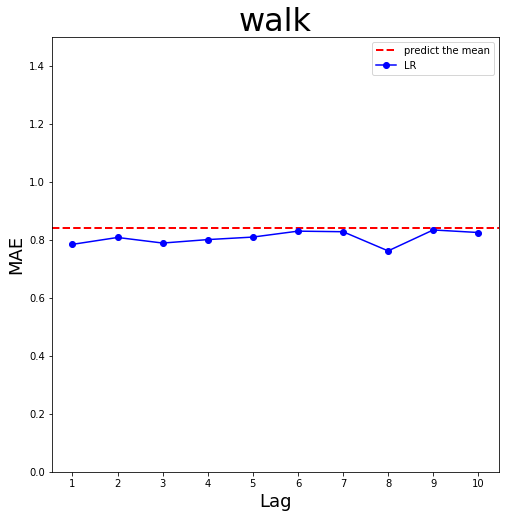

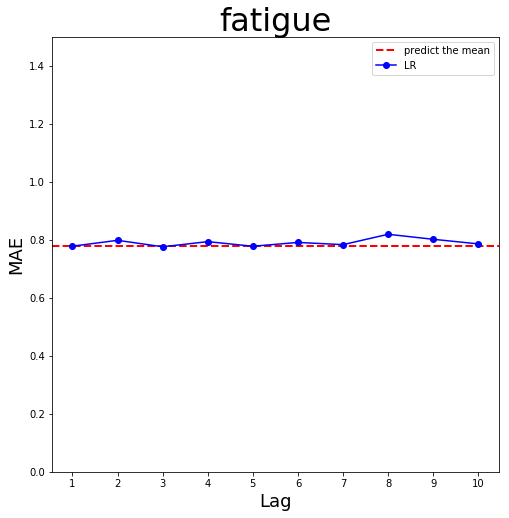

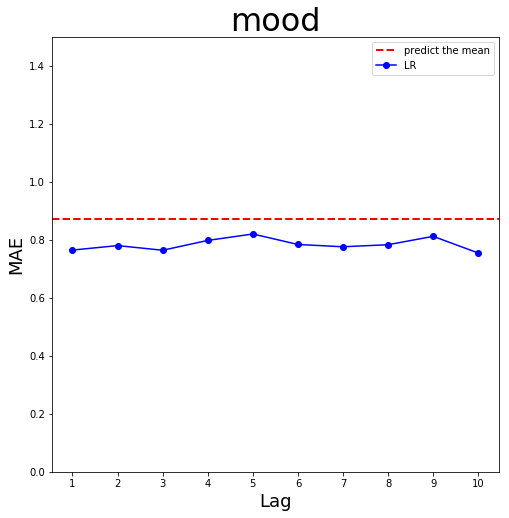

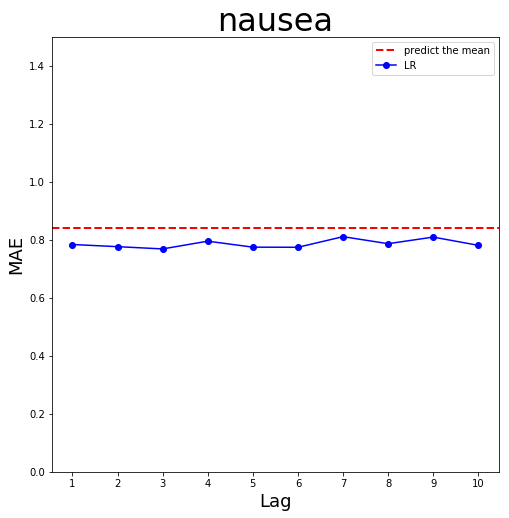

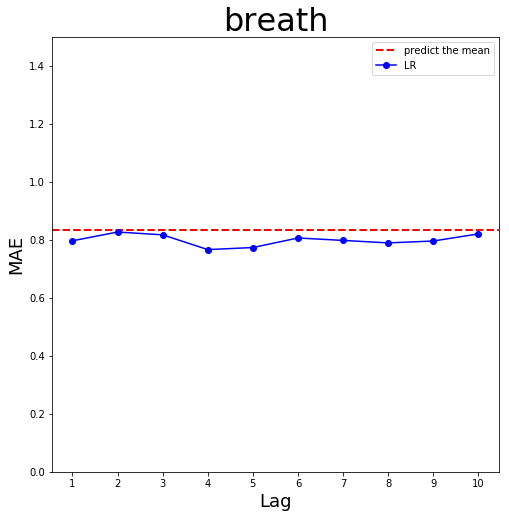

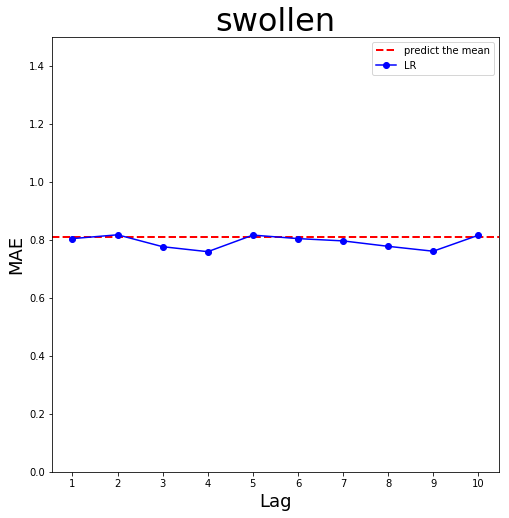

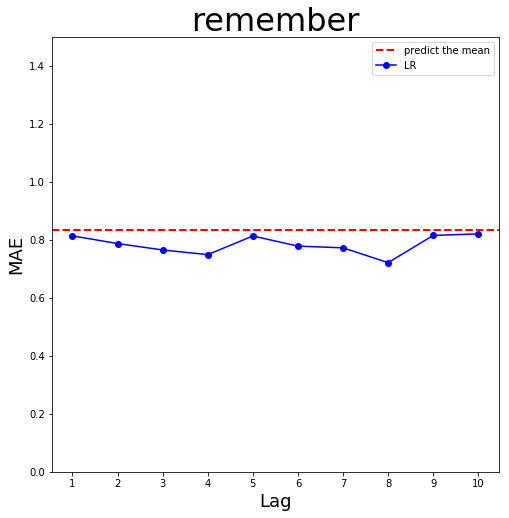

In [182]:
# outs = outs.squeeze(2)
# outs2 = outs2.squeeze(2)

x = np.arange(1, max_window-min_window+2)
y = np.stack(results_cv).squeeze()
colors = ["b", "k"]
labels = ["LR", "XGB"]

for i in range(7):
    fig, ax = plt.subplots(figsize=(8, 8))
#     ax.errorbar(x=x, y=y[:, :, i, 0].mean(0), yerr=y[:, :, i, 0].std(0), capsize=5, c=colors[0], label="LR")
#     ax.errorbar(x=x, y=y[:, :, i, 1].mean(0), yerr=y[:, :, i, 1].std(0), capsize=5, c=colors[1], label="XGB")

    ax.errorbar(x=x, y=y[:, i], marker="o", capsize=5, c=colors[0], label="LR")
#     ax.errorbar(x=x, y=y[:, i, 1], capsize=5, c=colors[1], label="XGB")

#     ax.errorbar(x=x, y=outs2[i].mean(-1), yerr=outs2[i].std(-1), capsize=5, c=colors[1], label="w outcome")
    ax.axhline(baselines[i], c="r", ls="--", lw=2, label="predict the mean")
    ax.set_xticks(x)
    ax.set_ylabel("MAE", fontsize=18)
    ax.set_xlabel("Lag", fontsize=18)
    ax.set_title(outcome_names[i], fontsize=32)
    ax.set_ylim([0, 1.5])
    ax.legend()
plt.show()

# Classification experiments

(Jenny, start here!)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier

def getClfDataset(users, window_size, offset=False, outcome=None, interpolate=True, normalize_x=True, normalize_y=False):
    X = []
    Y = []

    # Create dataset (this runs fast)
    for i, item in enumerate(users):
        y = item[outcome_names].to_numpy() # Pull out outcome labels
        
        x = item.drop(columns=outcome_names).to_numpy() # Drop outcome columns and convert to numpy array

        # Chop off last timesteps that aren't divisible by window_size
        n = largestDivisibleByKLessThanN(len(x), window_size)
        x, y = x[:n], y[:n]
        
        # Do we want to z-score normalize the input data?
        if normalize_x:
            x = np.array(nanzScore(pd.DataFrame(x), 0))
        
        # Do we want to z-score normalize the outcomes?
        if normalize_y:
            y = np.array(nanzScore(pd.DataFrame(y), 0))
        
        # Chop the time series into windows and flatten them
        # For instance, if we have 5 variables and a window-size of 10, we would create one instance with 50 features
        x = x.reshape(n//window_size, window_size*x.shape[1])
        y = y.reshape(n//window_size, window_size, len(outcome_names))#[:, :, label]
        X.append(x)
        Y.append(y)
    
    # Stack all users into one big array of shape (num_users, window_size*num_features)
    X = np.vstack(X)
    Y = np.vstack(Y)
    
    # Each user will have many missing values, how do we want to fill them in?
    # A smarter way to do this will be to have some sort of "fill_missing_value" code
    if interpolate:
        X = pd.DataFrame(X).interpolate("linear", 1)
    X = X.fillna(X.mean(0)).to_numpy() # Fill in any remaining missing values with the mean of that column --- this is kind of weird, because it's a mean across the population!
    
    # Split into training and testing
    train_ix = np.random.choice(len(X), int(0.9*len(X)), replace=False)
    test_ix = list(set(np.arange(len(X))) - set(train_ix))
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = Y[train_ix], Y[test_ix]
    return X_train, X_test, y_train, y_test

max_window = 10
window_range = range(1, 10) # what window sizes should we try?
th=4
normalized=False
thresholds = [th/7]if normalized else [th] # what thresholds should we try?, jenny changed "threshold" to "thresholds"
mnames = ["rf", "lr", "xgb"]

def get_outcome_dataset(y, X, threshold):
#     y = y[:, :, i] Jenny commented out this
    y = np.nanmean(y, 1)
#     X = X_train[~np.isnan(y)]
    X = X[~np.isnan(y)] #jenny changed this
    y = y[~np.isnan(y)]
    new_y = np.zeros_like(y)
    new_y[y > threshold] = 1
    y = new_y
    return X, y  

results_cv = []
for _ in tqdm(range(5)): #5-fold cross validation
    results_windows = []
    for window_size in window_range:
        # Split data into windows
        X_train, X_test, y_train, y_test = getClfDataset(users, window_size, normalize_y=normalized)
        results_thresholds = []
        for threshold in thresholds:
            results_outcomes = []
            for i, n in enumerate(outcome_names):
                
                # --- extract dataset for each outcome (just getting correct labels to predict) --- 
                X_train_i, y_train_i = get_outcome_dataset(y_train[:, :, i], X_train, threshold)
                X_test_i, y_test_i = get_outcome_dataset(y_test[:, :, i], X_test, threshold)

                results_models = []
                if "rf" in mnames:
                    model = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train_i, y_train_i)
                    y_pred = model.predict(X_test_i)
                    score = roc_auc_score(y_test_i, y_pred)
                    results_models.append(score)
                if "lr" in mnames:
                    model = LogisticRegression().fit(X_train_i, y_train_i)
                    y_pred = model.predict(X_test_i)
                    score = roc_auc_score(y_test_i, y_pred)
                    results_models.append(score)
                if "xgb" in mnames:
                    model = XGBClassifier(random_state = 42, max_depth=3, n_jobs = -1).fit(X_train_i, y_train_i)
                    y_pred = model.predict(X_test_i)
                    score = roc_auc_score(y_test_i, y_pred)
                    results_models.append(score)
                results_outcomes.append(results_models) #jenny changed model_outs to results_models
            results_thresholds.append(results_outcomes)
        results_windows.append(results_thresholds)
    results_cv.append(results_windows)

  0%|          | 0/5 [00:00<?, ?it/s]

[13:22:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:24:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:26:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:27:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

 20%|██        | 1/5 [1:30:39<6:02:39, 5439.90s/it]

[14:52:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:52:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:53:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:53:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

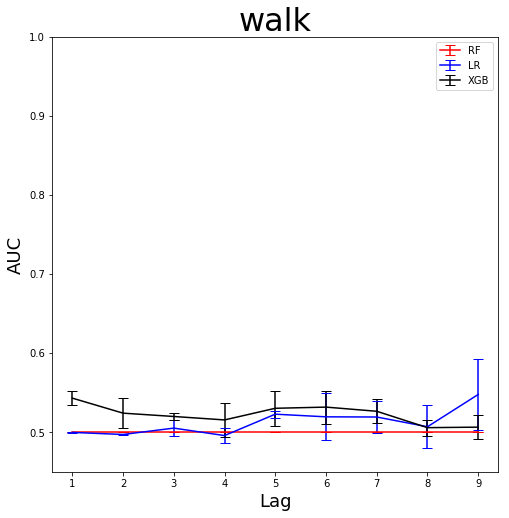

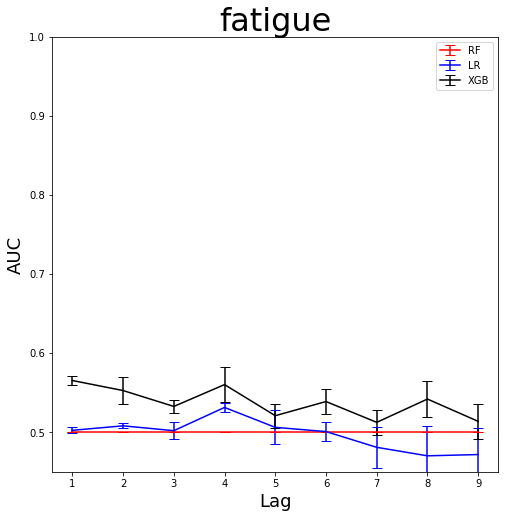

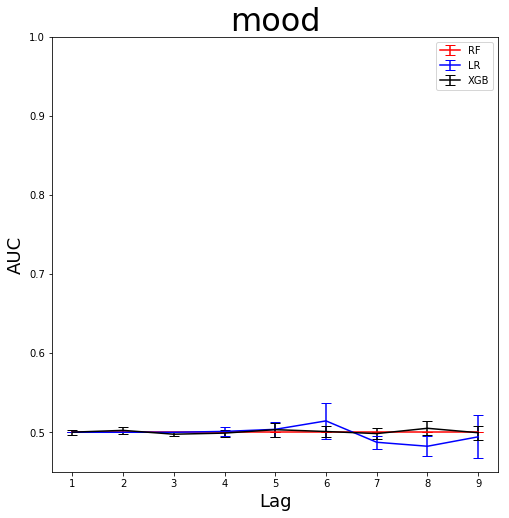

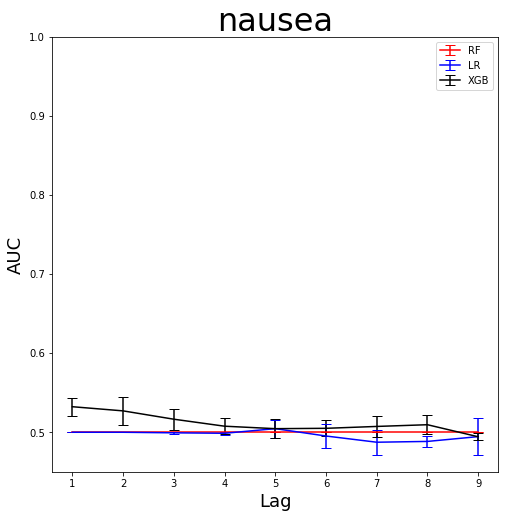

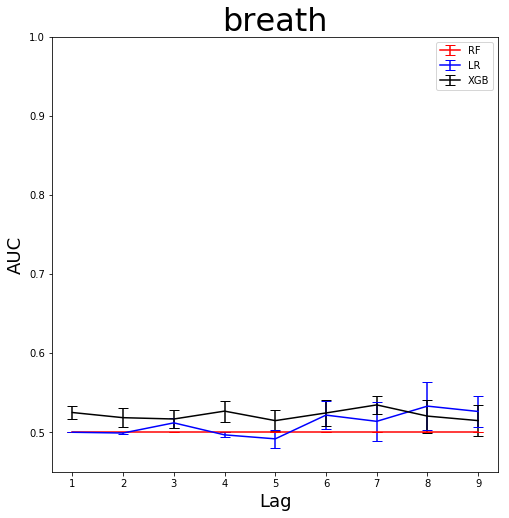

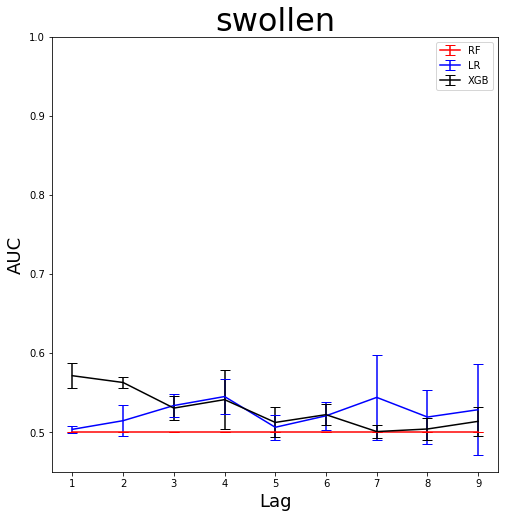

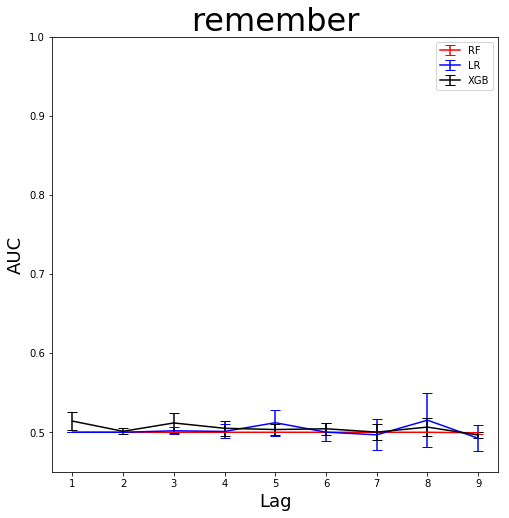

In [98]:
# THIS CODE BLOCK WON'T WORK YET. stacking results_cv will result in the wrong shape right now.
x = np.arange(1, max_window-min_window+1)
y = np.stack(results_cv).squeeze()
np.save(f'/mnt/results/results_array/thresholds-{thresholds[0]}-min_window-{min_window}-max_window-{max_window}-normalize-{normalized}.npy', y)

colors = ["r", "b", "k"]

for i in range(y.shape[2]):
    fig, ax = plt.subplots(figsize=(8, 8))
#     for j in range(y.shape[1]):
    ax.errorbar(x=x, y=y[:, :, i, 0].mean(0), yerr=y[:, :, i, 0].std(0), capsize=5, c=colors[0], label="RF")
    ax.errorbar(x=x, y=y[:, :, i, 1].mean(0), yerr=y[:, :, i, 1].std(0), capsize=5, c=colors[1], label="LR")
    ax.errorbar(x=x, y=y[:, :, i, 2].mean(0), yerr=y[:, :, i, 2].std(0), capsize=5, c=colors[2], label="XGB")

    ax.set_title(f'thresholds-{thresholds[0]}-window-{1+i}-normalize-{normalized}-')
    ax.set_xticks(x)
    ax.set_ylabel("AUC", fontsize=18)
    ax.set_xlabel("Lag", fontsize=18)
    ax.set_title(outcome_names[i], fontsize=32)
    ax.set_ylim([0.45, 1.0])
    ax.legend()
plt.show()